In [296]:
import pandas as pd
import statsmodels.formula.api as smf
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from patsy import dmatrices
import matplotlib.pyplot as plt
import seaborn as sns

# Citibike Data

In [5]:
df = pd.read_csv("../../data/citibike_sample_boros.csv")

In [6]:
df.head()

,starttime,hour,day,usertype,gender,age,tripduration_minutes,distance_miles,start_boro,end_boro
0,2020-10-27 16:51:37.994,16,Tuesday,Subscriber,male,37,21.816667,3.047236,Manhattan,Manhattan
1,2020-10-09 19:46:12.616,19,Friday,Subscriber,male,24,25.883333,1.418907,Manhattan,Manhattan
2,2020-10-10 15:19:17.455,15,Saturday,Subscriber,female,36,7.283333,0.502512,Brooklyn,Brooklyn
3,2020-10-28 01:30:42.644,1,Wednesday,Subscriber,male,31,24.833333,0.633161,Brooklyn,Brooklyn
4,2020-10-11 16:48:46.773,16,Sunday,Subscriber,male,42,19.633333,1.002208,Brooklyn,Brooklyn


In [14]:
# Create a categorical feature on distance_miles
# So that very short trips are modeled differently than medium or long trips
def create_distance_categories (x, breakpoints):
    if x < breakpoints[0]:
        return "round_trip"
    elif x >= breakpoints[0] and x < breakpoints[1]:
        return "medium"
    elif x >= breakpoints[1]:
        return "long"

In [15]:
breakpoints = [0.35170135515426265, 2.227413634420242]

In [16]:
df['distance_category'] = df['distance_miles'].apply(lambda x: create_distance_categories(x, breakpoints))

# Linear Regression with Statsmodels

First, let's fit a good old fashioned linear regression model using statsmodels library.

In [113]:
formula = "tripduration_minutes ~ distance_category + usertype + distance_miles + start_boro + day + hour + gender + age"

In [114]:
linear_regression = smf.ols(formula, data=df).fit()

In [115]:
print("Linear Regression R-Squared:", round(linear_regression.rsquared,2))

Linear Regression R-Squared: 0.32


In [122]:
linear_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     tripduration_minutes   R-squared:                       0.318
Model:                              OLS   Adj. R-squared:                  0.318
Method:                   Least Squares   F-statistic:                 1.372e+04
Date:                  Sun, 16 Apr 2023   Prob (F-statistic):               0.00
Time:                          16:59:14   Log-Likelihood:            -1.9541e+06
No. Observations:                500000   AIC:                         3.908e+06
Df Residuals:                    499982   BIC:                         3.908e+06
Df Model:                            17                                         
Covariance Type:              nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          13.3496      0.198     67.329      0.000      12.961      13.738
distance_category[T.medium]        -1.2559      0.078    -16.148      0.000      -1.408      -1.103
distance_category[T.round_trip]    11.6381      0.112    103.834      0.000      11.418      11.858
usertype[T.Subscriber]             -5.5564      0.048   -116.334      0.000      -5.650      -5.463
start_boro[T.Brooklyn]             -4.3424      0.147    -29.459      0.000      -4.631      -4.053
start_boro[T.Manhattan]            -4.2213      0.144    -29.328      0.000      -4.503      -3.939
start_boro[T.Queens]               -4.2015      0.168    -25.005      0.000      -4.531      -3.872
day[T.Monday]                      -0.2144      0.071     -3.015      0.003      -0.354      -0.075
day[T.Saturday]                     2.2379      0.059     37.664      0.000       2.121       2.354
day[T.Sunday]                       1.9172      0.065     29.412      0.000       1.789       2.045
day[T.Thursday]                     0.1373      0.062      2.229      0.026       0.017       0.258
day[T.Tuesday]                     -0.2043      0.065     -3.131      0.002      -0.332      -0.076
day[T.Wednesday]                   -0.0603      0.064     -0.944      0.345      -0.186       0.065
gender[T.male]                     -1.5450      0.039    -40.078      0.000      -1.621      -1.469
gender[T.unknown]                  -1.2222      0.073    -16.842      0.000      -1.364      -1.080
distance_miles                      6.8606      0.029    240.520      0.000       6.805       6.917
hour                                0.1416      0.004     38.589      0.000       0.134       0.149
age                                 0.0288      0.002     18.861      0.000       0.026       0.032
==============================================================================
Omnibus:                   452526.877   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         22868874.261
Skew:                           4.264   Prob(JB):                         0.00
Kurtosis:                      35.015   Cond. No.                         744.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Linear Regression with scikit-learn

Next, let's use scikit-learn to train a linear regression model, just to get familiar with how scikit-learn works.

scikit-learn needs the target variable (y) and the feature variables (x) to be DataFrames.

In [117]:
y, x = dmatrices(formula, data=df, return_type='dataframe')

In [118]:
sklearn_linear_regression = LinearRegression()

In [119]:
sklearn_linear_regression.fit(x, y)

LinearRegression()

In [120]:
y_pred = sklearn_linear_regression.predict(x)

In [121]:
print("Scikit-learn Linear Regression R-Squared:", round(r2_score(y, y_pred),2))

Scikit-learn Linear Regression R-Squared: 0.32


As expected, the r-squared is identical whether we use statsmodels or scikit-learn. The advantage of using statsmodels is that it has nice summary() function to see all the coefficients and test diagnostics.

# Decision Tree with scikit-learn

Let's see if we can improve on this R-Squared with a Decision Tree.

In [124]:
decision_tree_regression = DecisionTreeRegressor()

In [125]:
decision_tree_regression.fit(x, y)

DecisionTreeRegressor()

In [126]:
y_pred = decision_tree_regression.predict(x)

In [127]:
r2_score(y, y_pred)

0.9605847933447457

Whoa! That is a suspiciously high R-Squared score. What's going on?

Decision-tree learners can create over-complex trees that do not generalize the data well. This is called overfitting. Mechanisms such as pruning, setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.

Let's try splitting the data into a training dataset and a testing dataset in order to check for overfitting. We will train the Decision Tree on the training data (80% of the data), and then test it's accuracy on the testing data (20% of the data).

In [211]:
from sklearn.model_selection import train_test_split

In [212]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.80, random_state=42)

In [213]:
decision_tree_regression.fit(x_train, y_train)

DecisionTreeRegressor()

In [214]:
y_pred_test = decision_tree_regression.predict(x_test)

In [215]:
r2_score(y_test, y_pred_test)

-0.35093970686080644

As we see, our Decision Tree performs very badly on the testing data. We clearly have overfitting.

## Decision Tree with Max Depth = 2

As we see below, our original DT model has a depth of 49:

In [217]:
decision_tree_regression.get_depth()

49

Let's start with a much smaller, simpler decision tree with a depth of just 2.

In [218]:
decision_tree_regression_v2 = DecisionTreeRegressor(max_depth=2)

In [219]:
decision_tree_regression_v2.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=2)

In [220]:
y_pred_v2 = decision_tree_regression_v2.predict(x_test)

In [221]:
print("Decision Tree (Max Depth = 2) R-Squared on Test Data:", round(r2_score(y_test, y_pred_v2),2))

Decision Tree (Max Depth = 2) R-Squared on Test Data: 0.26


Let's plot the decision points.

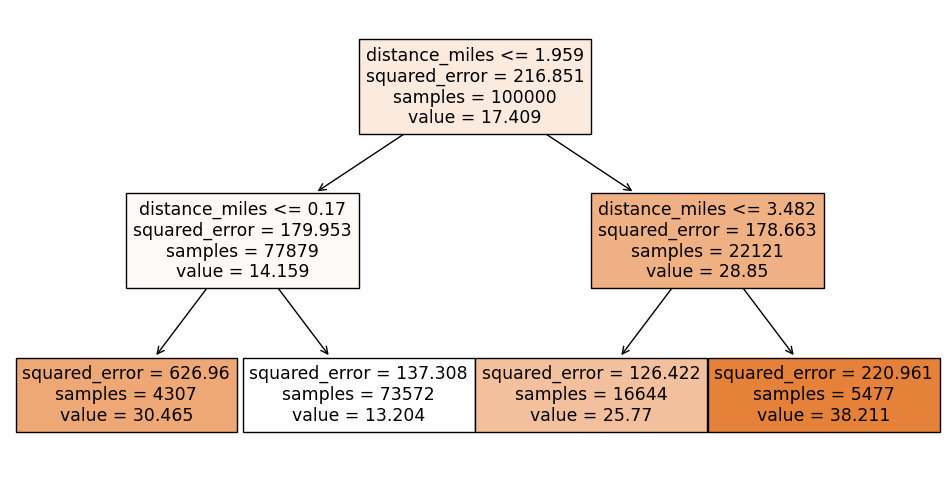

In [222]:
fig = plt.figure(figsize=(12,6))
_ = tree.plot_tree(decision_tree_regression_v2,
                   feature_names=X.columns,
                   filled=True)

## Decision Tree with Max Depth = 3

In [223]:
decision_tree_regression_v3 = DecisionTreeRegressor(max_depth=3)

In [224]:
decision_tree_regression_v3.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [225]:
y_pred_v3 = decision_tree_regression_v3.predict(x_test)

In [190]:
print("Decision Tree (Max Depth = 3) R-Squared on Test Data:", round(r2_score(y_test, y_pred_v3),2))

Decision Tree (Max Depth = 3) R-Squared on Test Data: 0.31


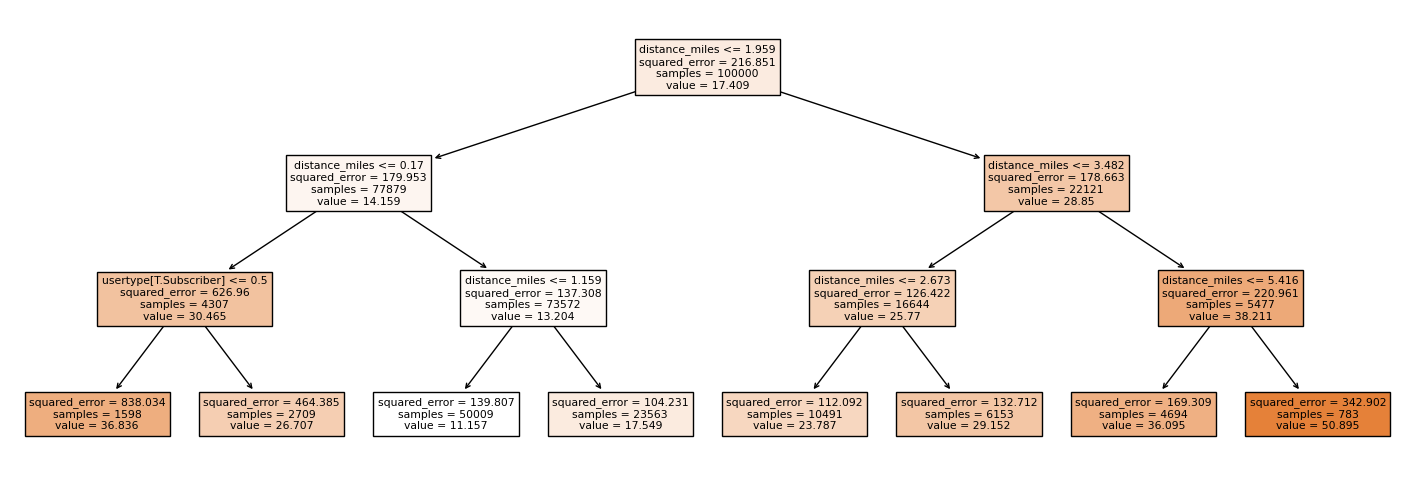

In [226]:
fig = plt.figure(figsize=(18,6))
_ = tree.plot_tree(decision_tree_regression_v3,
                   feature_names=X.columns,
                   filled=True)

# Decision Tree with Max Depth = 4

In [227]:
decision_tree_regression_v4 = DecisionTreeRegressor(max_depth=4)

In [228]:
decision_tree_regression_v4.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=4)

In [229]:
y_pred_v4 = decision_tree_regression_v4.predict(x_test)

In [230]:
print("Decision Tree (Max Depth = 4) R-Squared on Test Data:", round(r2_score(y_test, y_pred_v4),2))

Decision Tree (Max Depth = 4) R-Squared on Test Data: 0.33


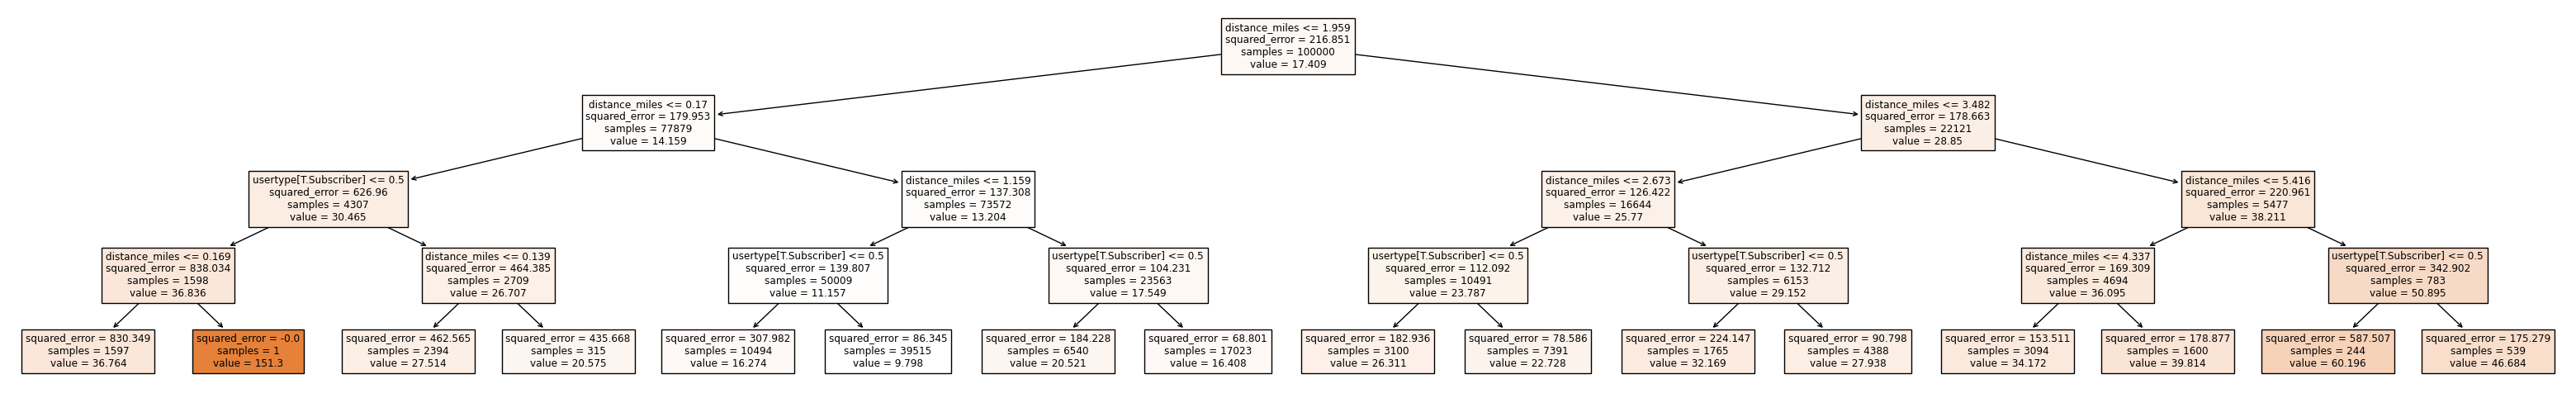

In [231]:
fig = plt.figure(figsize=(40,6))
_ = tree.plot_tree(decision_tree_regression_v4,
                   feature_names=X.columns,
                   filled=True)

# Decision Tree with Max Depth = 20

In [316]:
decision_tree_regression_v20 = DecisionTreeRegressor(max_depth=20)

In [317]:
decision_tree_regression_v20.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=20)

In [318]:
y_pred_v20 = decision_tree_regression_v20.predict(x_test)

In [319]:
print("Decision Tree (Max Depth = 20) R-Squared on Test Data:", round(r2_score(y_test, y_pred_v20),2))

Decision Tree (Max Depth = 20) R-Squared on Test Data: -0.16


# Decision Treee Hyperparameter Tuning

There are mainly two methods.

1) Using Scikit-learn train_test_split() function
2) Using k-fold cross-validation

First, plot mean squared error comparing training error vs testing error.

In [309]:
from sklearn.metrics import mean_squared_error as mse

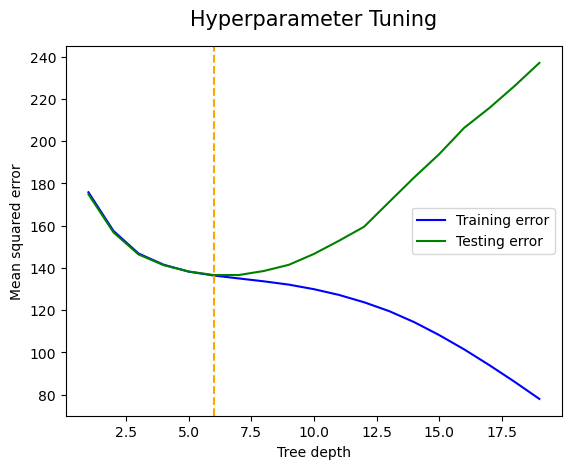

In [314]:
max_depths = range(1, 20)
training_error = []
for max_depth in max_depths:
    model_1 = DecisionTreeRegressor(max_depth=max_depth)
    model_1.fit(x, y)
    training_error.append(mse(y, model_1.predict(x)))
    
testing_error = []
for max_depth in max_depths:
    model_2 = DecisionTreeRegressor(max_depth=max_depth)
    model_2.fit(x_train, y_train)
    testing_error.append(mse(y_test, model_2.predict(x_test)))

plt.plot(max_depths, training_error, color='blue', label='Training error')
plt.plot(max_depths, testing_error, color='green', label='Testing error')
plt.xlabel('Tree depth')
plt.axvline(x=6, color='orange', linestyle='--')
plt.ylabel('Mean squared error')
plt.title('Hyperparameter Tuning', pad=15, size=15)
plt.legend();

At the point of tree depth = 6, the testing error begins to increase although the training error decreases continuously. From this plot, we can confirm that the optimum value for max_depth hyperparameter is 6.

A more precise way to tune the model hyperparameter is to use the k-fold cross-validation. By using this method, you can tune more than 1 hyperparameter simultaneously. Here, training proceeds on the training set, after which evaluation is done on the validation set and the final evaluation can be done on the test set. However, partitioning the original dataset into 3 sets (train, validation and test) drastically reduces the available data for the training process.

As a solution, we use a procedure called k-fold cross-validation where k is the number of folds (which is usually 5 or 10). In k-fold cross-validation,

We first divide the original dataset into the train set and test set using train_test_split() function. The train set is further divided into k-number of folds. The model is trained using k−1 of the folds and validated on the remaining fold. The process is done k times and the performance measure is reported at each execution. Then it takes the average. After finding the parameters, the final evaluation is done on the test set.

Source: https://towardsdatascience.com/train-a-regression-model-using-a-decision-tree-70012c22bcc1

Tuning hyperparameters can be done using the Grid Search method along with k-fold cross-validation. The equivalent Scikit-learn function is GridSearchCV. It finds all the hyperparameter combinations for a specified k number of folds.

In [320]:
from sklearn.model_selection import GridSearchCV

In [337]:
model = DecisionTreeRegressor()

In [340]:
gs = GridSearchCV(model,
                  param_grid = {'max_depth': range(1, 11),
                                'min_samples_split': range(5, 50, 5)
                               },
                  cv=5,
                  n_jobs=1,
                  scoring='neg_mean_squared_error')

In [341]:
gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=1,
             param_grid={'max_depth': range(1, 11),
                         'min_samples_split': range(5, 50, 5)},
             scoring='neg_mean_squared_error')

In [342]:
print(gs.best_params_)

{'max_depth': 7, 'min_samples_split': 40}


Now, we can create the best model using these optimum values. It avoids both overfitting and underfitting conditions.

In [347]:
final_decision_tree = DecisionTreeRegressor(max_depth=7,
                                  min_samples_split=40)

In [348]:
final_decision_tree.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=7, min_samples_split=40)

In [349]:
y_pred_final = final_decision_tree.predict(x_test)

In [350]:
print("Decision Tree (Optimized) R-Squared on Test Data:", round(r2_score(y_test, y_pred_final),2))

Decision Tree (Optimized) R-Squared on Test Data: 0.36


# Visualize Feature Importances

In [367]:
feature_importance_df = pd.DataFrame()
feature_importance_df['importance'] = final_decision_tree.feature_importances_
feature_importance_df.index = final_decision_tree.feature_names_in_

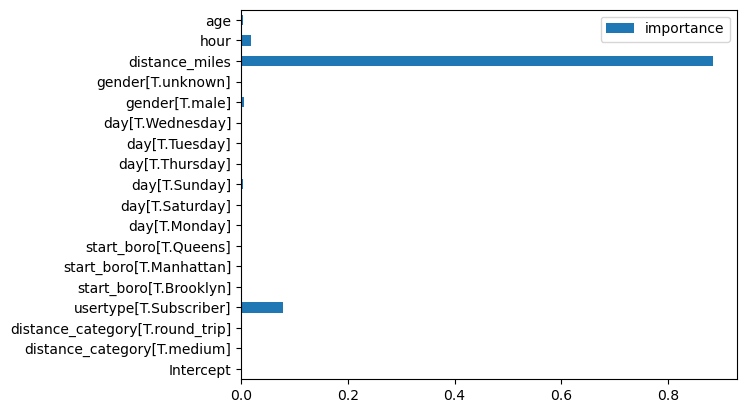

In [368]:
feature_importance_df.plot(kind='barh');

# Random Forest

Let's see if we can train a random forest model to outperform the decision tree.

In [388]:
from sklearn.ensemble import RandomForestRegressor

In [389]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=7, min_samples_split=5)

In [390]:
rf_model.fit(x_train, y_train);

/var/folders/8d/8s96zp0d3rl7n94km_15vkzw0000gp/T/ipykernel_45820/1099038904.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(x_train, y_train);


In [391]:
y_pred_rf = rf_model.predict(x_test)

In [392]:
print("Random Forest R-Squared on Test Data:", round(r2_score(y_test, y_pred_rf),2))

Random Forest R-Squared on Test Data: 0.37


On first try, our Random Forest model slightly outperforms the optimized Decision Tree.

Let's run a Grid Search to find the optimal random forest hyperparameters.

In [422]:
# Hide data conversion warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Progress bar
from pactools.grid_search import GridSearchCVProgressBar

In [423]:
rf_model = RandomForestRegressor()

In [424]:
gs = GridSearchCVProgressBar(rf_model,
                  param_grid = {'n_estimators': range(10, 200, 10),
                                'max_depth': range(1, 11),
                                'min_samples_split': range(5, 50, 5)
                               },
                  cv=5,
                  n_jobs=1,
                  verbose=1,
                  scoring='neg_mean_squared_error');

In [ ]:
gs.fit(x_train, y_train)

Fitting 5 folds for each of 1710 candidates, totalling 8550 fits


In [ ]:
print(gs.best_params_)

In [ ]:
final_random_forest = RandomForestRegressor(n_estimators=100, max_depth=7,
                                  min_samples_split=40)